In [1295]:
import scanpy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Select dataset

In [1296]:
# dataset = ("data","wildtype","rep1")
# dataset = ("data","wildtype","rep2")
# dataset = ("data","wildtype","rep3")
# dataset = ("data","T_mutant","rep1")
# dataset = ("data","T_mutant","rep2")
# dataset = ("data","Eomes_mutant","rep1")
dataset = ("data","Eomes_mutant","rep2")

In [1297]:
dataset_name = f"{dataset[1]}_{dataset[2]}"
filename = os.path.join(*dataset) + "/adata.h5ad"

In [1298]:
adata = scp.read_h5ad(filename)
adata.layers["counts"] = adata.X.copy()

In [1299]:
parameters = pd.read_csv("parameters_by_batch.csv", index_col=0).loc[dataset_name, :].to_dict()
print("Parameters: ")
parameters

Parameters: 


{'total_counts_min': 4000,
 'total_counts_max': 40000,
 'n_genes_by_counts_min': 2000,
 'n_genes_by_counts_max': 8000,
 'pct_counts_mt_min': 1,
 'pct_counts_mt_max': 7.5,
 'doublet_score_max': 0.1,
 'n_top_genes': 2000,
 'mean_neighbor_distance_max': 0.0175,
 'n_top_genes.1': 2000,
 'n_pcs': 20,
 'n_neighbors': 15,
 'cell_cycle_regression': True,
 'resolutions': '[0.1,0.5]'}

In [1300]:
if not os.path.exists(f"figures/{dataset_name}"):
    os.makedirs(f"figures/{dataset_name}")

if not os.path.exists(f"tables/{dataset_name}"):
    os.makedirs(f"tables/{dataset_name}")

if not os.path.exists('script_versions'):
    os.makedirs('script_versions')

# QC

## Basic metrics

In [1301]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [1302]:
scp.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

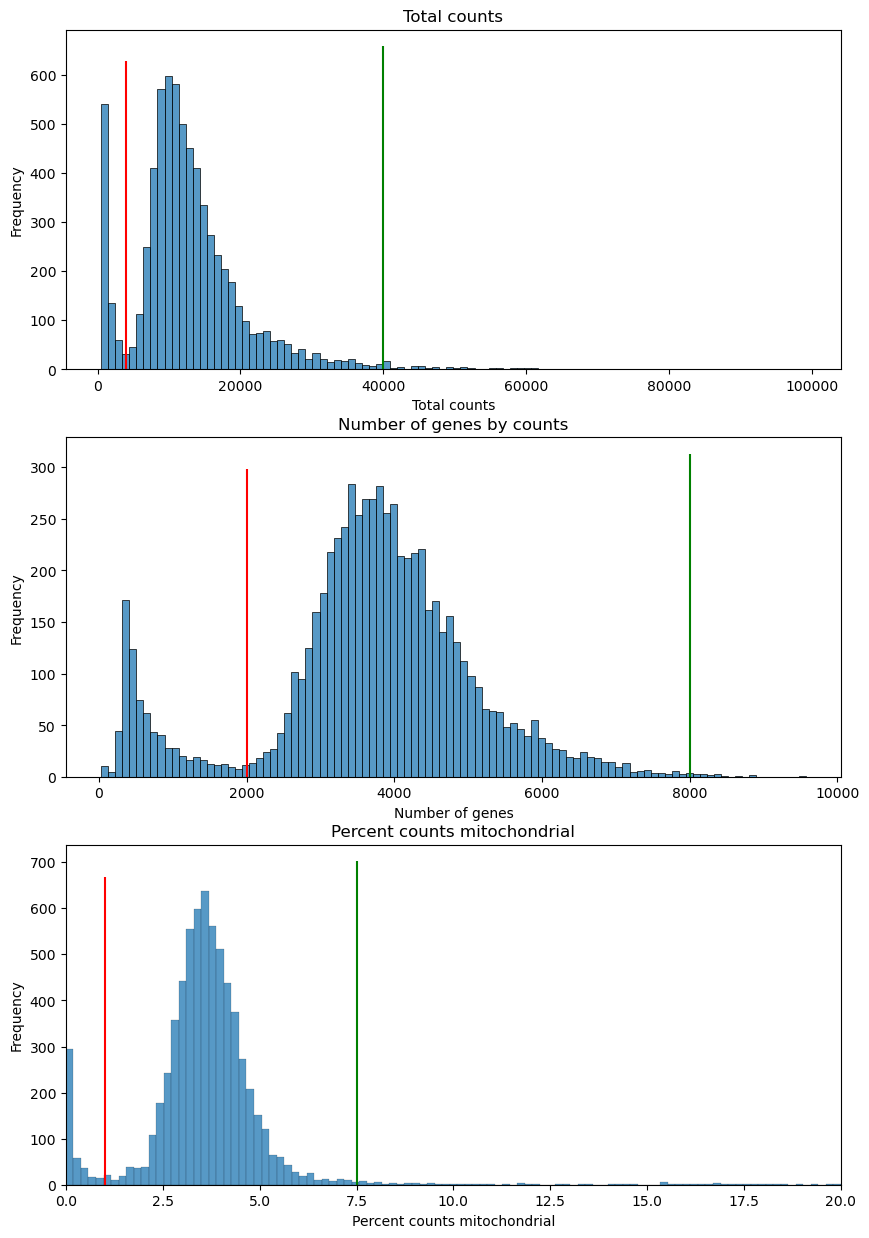

In [1303]:
obs = adata.obs.loc[adata.obs["total_counts"] > 500, :]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.histplot(obs["total_counts"], bins=100, ax=ax[0])
ax[0].vlines(parameters["total_counts_min"], 0, ax[0].get_ylim()[1], color="red", label="min")
ax[0].vlines(parameters["total_counts_max"], 0, ax[0].get_ylim()[1], color="green", label="max")
ax[0].set_title("Total counts")
ax[0].set_xlabel("Total counts")
ax[0].set_ylabel("Frequency")
# ax[0].set_yscale("log")

sns.histplot(obs["n_genes_by_counts"], bins=100, ax=ax[1])
ax[1].vlines(parameters["n_genes_by_counts_min"], 0, ax[1].get_ylim()[1], color="red", label="min")
ax[1].vlines(parameters["n_genes_by_counts_max"], 0, ax[1].get_ylim()[1], color="green", label="max")
ax[1].set_title("Number of genes by counts")
ax[1].set_xlabel("Number of genes")
ax[1].set_ylabel("Frequency")
# ax[1].set_yscale("log")

sns.histplot(obs["pct_counts_mt"], bins=500, ax=ax[2])
ax[2].vlines(parameters["pct_counts_mt_min"], 0, ax[2].get_ylim()[1], color="red", label="min")
ax[2].vlines(parameters["pct_counts_mt_max"], 0, ax[2].get_ylim()[1], color="green", label="max")
ax[2].vlines
ax[2].set_title("Percent counts mitochondrial")
ax[2].set_xlabel("Percent counts mitochondrial")
ax[2].set_xlim(0, 20)
ax[2].set_ylabel("Frequency")
# ax[2].set_yscale("log")

fig.savefig(f"figures/{dataset_name}/qc_metrics.png", bbox_inches="tight", transparent=True, dpi=300)

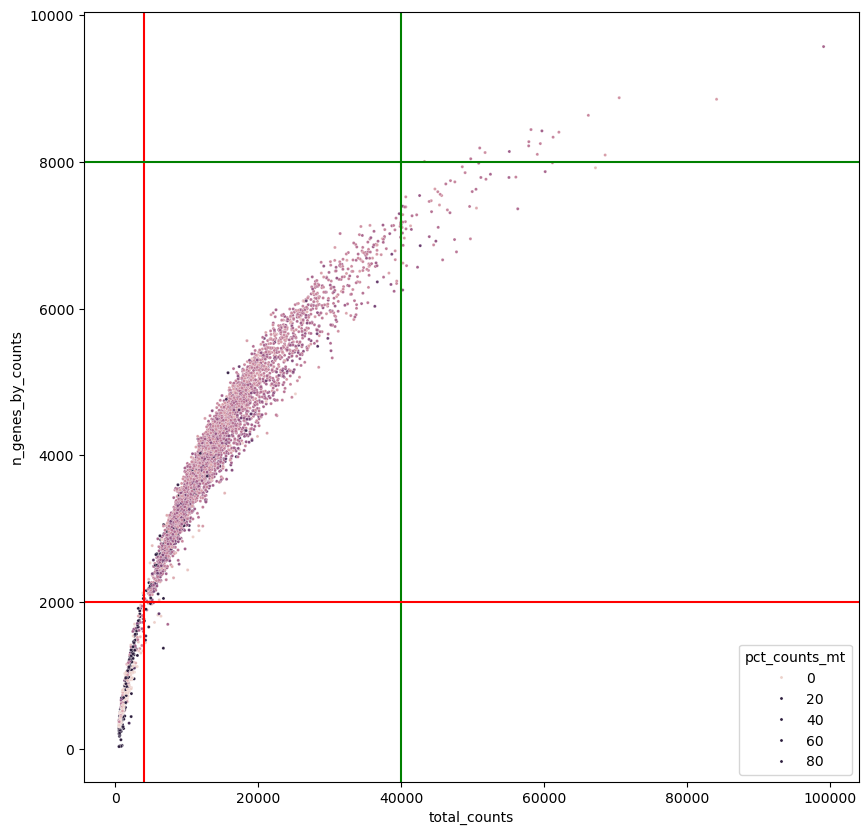

In [1304]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(x="total_counts", y="n_genes_by_counts", hue="pct_counts_mt", hue_norm=(parameters["pct_counts_mt_min"],parameters["pct_counts_mt_max"]), s=5, data=obs, ax=ax)
ax.axvline(parameters["total_counts_min"], color="red", label="min")
ax.axvline(parameters["total_counts_max"], color="green", label="max")
ax.axhline(parameters["n_genes_by_counts_min"], color="red")
ax.axhline(parameters["n_genes_by_counts_max"], color="green")

fig.savefig(f"figures/{dataset_name}/qc_metrics_scatterplot.png", bbox_inches="tight", transparent=True, dpi=300)

In [1305]:
adata = adata[adata.obs["total_counts"] > parameters["total_counts_min"], :]
adata = adata[adata.obs["total_counts"] < parameters["total_counts_max"], :]
adata = adata[adata.obs["n_genes_by_counts"] > parameters["n_genes_by_counts_min"], :]
adata = adata[adata.obs["n_genes_by_counts"] < parameters["n_genes_by_counts_max"], :]
adata = adata[adata.obs["pct_counts_mt"] > parameters["pct_counts_mt_min"], :]
adata = adata[adata.obs["pct_counts_mt"] < parameters["pct_counts_mt_max"], :]

## Doublets

In [1306]:
scp.pp.scrublet(adata)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/scanpy/preprocessing/_scrublet/__init__.py:289: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


In [1307]:
adata_ = scp.pp.normalize_total(adata, copy=True)
scp.pp.log1p(adata_)
scp.pp.highly_variable_genes(adata_)
scp.pp.pca(adata_, n_comps=20, use_highly_variable=True)
scp.pp.neighbors(adata_)
scp.tl.umap(adata_)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


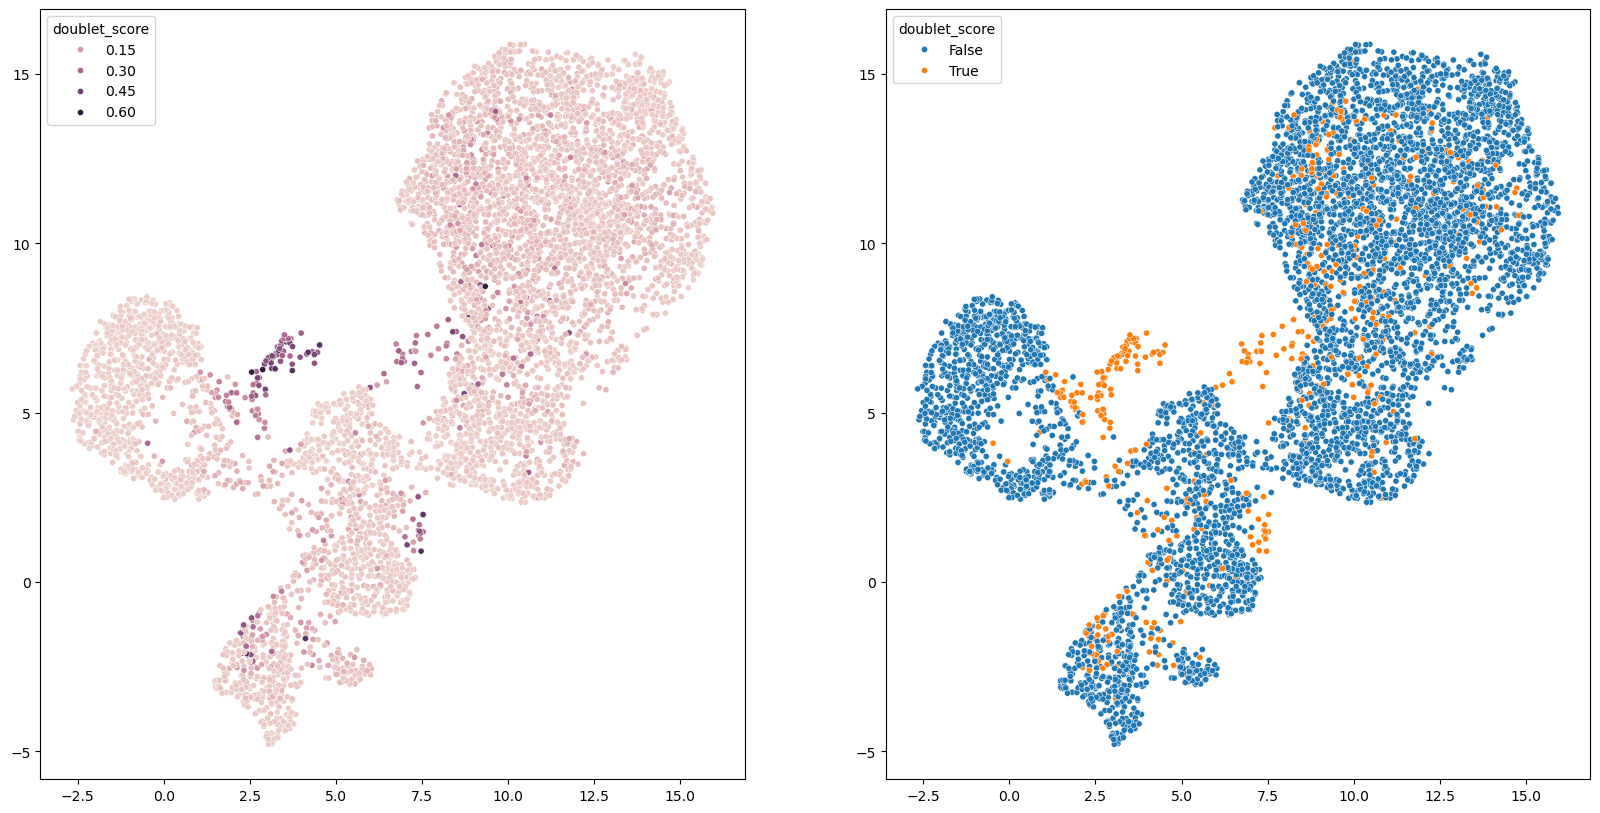

In [1308]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

X = adata_.obsm["X_umap"]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata.obs["doublet_score"], s=20, ax=ax[0])

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata.obs["doublet_score"]>parameters["doublet_score_max"], s=20, ax=ax[1])

fig.savefig(f"figures/{dataset_name}/doublet_score.png", bbox_inches="tight", transparent=True, dpi=300)

In [1309]:
adata = adata[adata.obs["doublet_score"] < parameters["doublet_score_max"], :]

In [1310]:
del adata_

## Outliers 

In [1311]:
adata_ = scp.pp.normalize_total(adata, copy=True)
scp.pp.log1p(adata_)
scp.pp.highly_variable_genes(adata_)
scp.pp.pca(adata_, n_comps=20, use_highly_variable=True)
scp.pp.neighbors(adata_)
scp.tl.umap(adata_)

adata_.obs["mean_neighbor_distance"] = adata_.obsp["distances"].mean(axis=1)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


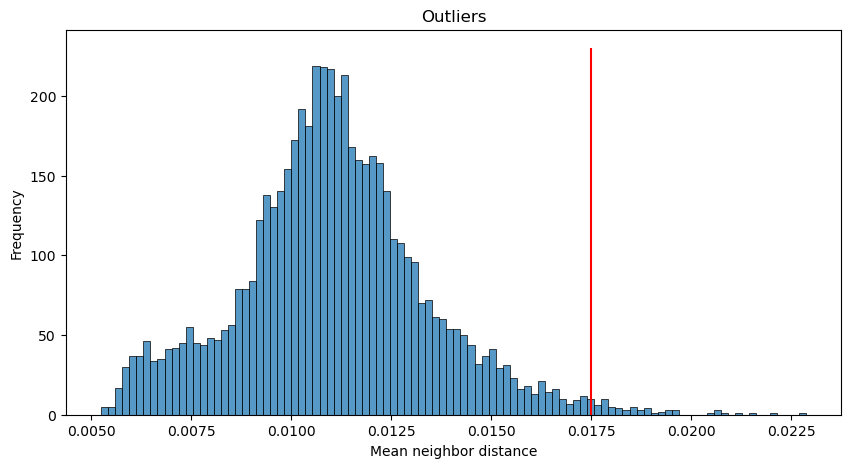

In [1312]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(adata_.obs["mean_neighbor_distance"], bins=100, ax=ax)
ax.vlines(parameters["mean_neighbor_distance_max"], 0, ax.get_ylim()[1], color="red", label="max")
ax.set_title("Outliers")
ax.set_xlabel("Mean neighbor distance")
ax.set_ylabel("Frequency")

fig.savefig(f"figures/{dataset_name}/mean_neighbor_distance.png", bbox_inches="tight", transparent=True, dpi=300)

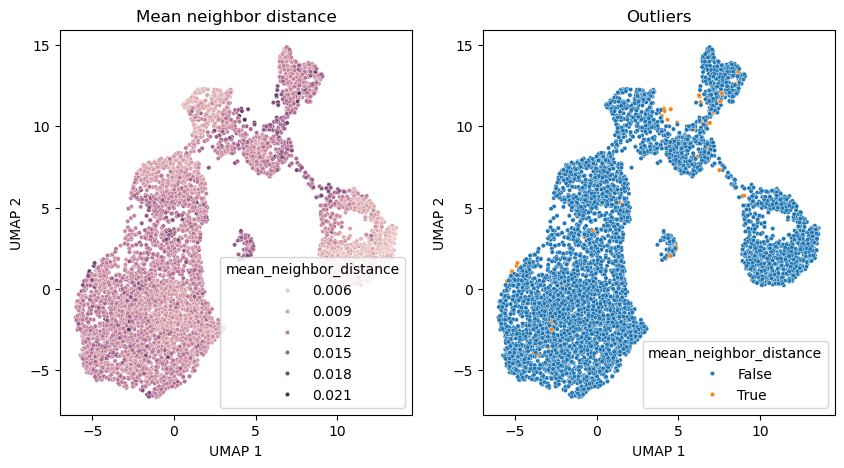

In [1313]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

X = adata_.obsm["X_umap"]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata_.obs["mean_neighbor_distance"], s=10, ax=ax[0])
ax[0].set_title("Mean neighbor distance")
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("UMAP 2")

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata_.obs["mean_neighbor_distance"]>parameters["mean_neighbor_distance_max"], s=10, ax=ax[1])
ax[1].set_title("Outliers")
ax[1].set_xlabel("UMAP 1")
ax[1].set_ylabel("UMAP 2")

fig.savefig(f"figures/{dataset_name}/mean_neighbor_distance_scatterplot.png", bbox_inches="tight", transparent=True, dpi=300)

In [1314]:
adata = adata[adata_.obs["mean_neighbor_distance"] < parameters["mean_neighbor_distance_max"], :]

In [1315]:
del adata_

# Normalization

In [1316]:
scp.pp.normalize_total(adata)
scp.pp.log1p(adata)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Dimensionality reduction

## Feature selection

In [1317]:
scp.pp.highly_variable_genes(adata, n_top_genes=parameters["n_top_genes"])

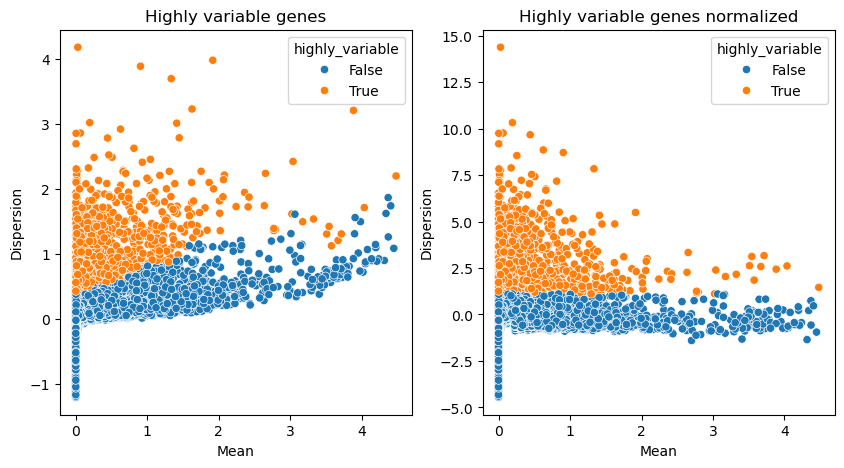

In [1318]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x="means", y="dispersions", hue="highly_variable", data=adata.var, ax=ax[0])
ax[0].set_title("Highly variable genes")
ax[0].set_xlabel("Mean")
ax[0].set_ylabel("Dispersion")

sns.scatterplot(x="means", y="dispersions_norm", hue="highly_variable", data=adata.var, ax=ax[1])
ax[1].set_title("Highly variable genes normalized")
ax[1].set_xlabel("Mean")
ax[1].set_ylabel("Dispersion")

fig.savefig(f"figures/{dataset_name}/highly_variable_genes.png", bbox_inches="tight", transparent=True, dpi=300)

## PCA

In [1319]:
scp.pp.pca(adata, n_comps=100, use_highly_variable=True)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


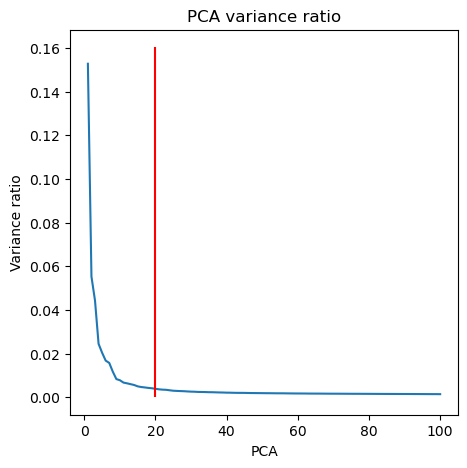

In [1320]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.lineplot(x=range(1, 101), y=adata.uns["pca"]["variance_ratio"], ax=ax)
ax.vlines(parameters["n_pcs"], 0, ax.get_ylim()[1], color="red", label="min")
ax.set_title("PCA variance ratio")
ax.set_xlabel("PCA")
ax.set_ylabel("Variance ratio")

fig.savefig(f"figures/{dataset_name}/pca_variance_ratio.png", bbox_inches="tight", transparent=True, dpi=300)

In [1321]:
scp.pp.pca(adata, n_comps=parameters["n_pcs"], use_highly_variable=True)

/Users/gatocor/miniforge3/envs/scrnaseq_vitamin_a/lib/python3.13/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


## UMAP

In [1322]:
scp.pp.neighbors(adata, use_rep="X_pca", key_added="neighbors_pca", n_neighbors=parameters["n_neighbors"], n_pcs=parameters["n_pcs"])
scp.tl.umap(adata, neighbors_key="neighbors_pca")
adata.obsm["X_umap_pca"] = adata.obsm["X_umap"]

# Other corrections

## Cell cycle correction

In [1323]:
s_genes = [i for i in pd.read_csv("cell_cycle_G1_S.txt",header=None).values.flatten() if i in adata.var_names]
g2m_genes = [i for i in pd.read_csv("cell_cycle_G2_M.txt",header=None).values.flatten() if i in adata.var_names]

cycle_genes = s_genes+g2m_genes

In [1324]:
scp.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

scp.external.pp.harmony_integrate(adata, "phase", basis="X_pca", adjusted_basis="X_pca_phase")

2025-03-03 10:30:54,761 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-03 10:30:55,734 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-03 10:30:55,759 - harmonypy - INFO - Iteration 1 of 10
2025-03-03 10:30:59,060 - harmonypy - INFO - Iteration 2 of 10
2025-03-03 10:30:59,920 - harmonypy - INFO - Iteration 3 of 10
2025-03-03 10:31:00,801 - harmonypy - INFO - Converged after 3 iterations


In [1325]:
scp.pp.neighbors(adata, use_rep="X_pca_phase", key_added="neighbors_pca_phase", n_neighbors=parameters["n_neighbors"], n_pcs=parameters["n_pcs"])
scp.tl.umap(adata, neighbors_key="neighbors_pca_phase")
adata.obsm["X_umap_pca_phase"] = adata.obsm["X_umap"]

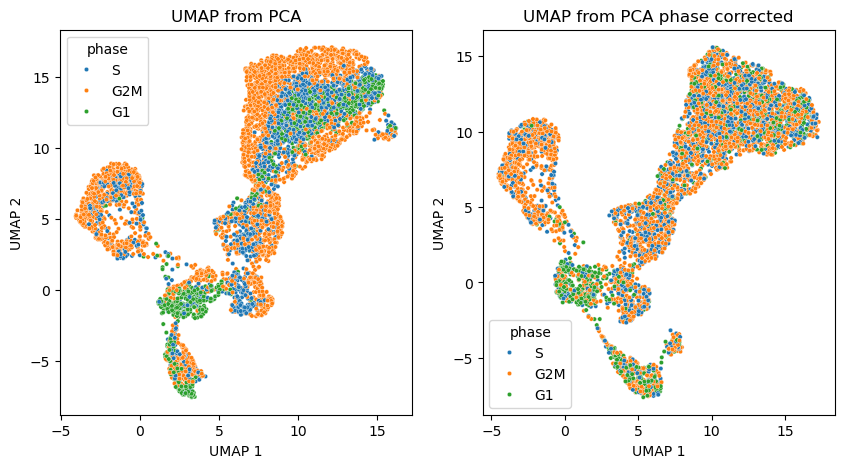

In [1326]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

X = adata.obsm["X_umap_pca"]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata.obs["phase"], s=10, ax=ax[0])
ax[0].set_title("UMAP from PCA")
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("UMAP 2")

X = adata.obsm["X_umap_pca_phase"]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata.obs["phase"], s=10, ax=ax[1])
ax[1].set_title("UMAP from PCA phase corrected")
ax[1].set_xlabel("UMAP 1")
ax[1].set_ylabel("UMAP 2")

fig.savefig(f"figures/{dataset_name}/umap_pca_vs_pca_phase.png", bbox_inches="tight", transparent=True, dpi=300)

In [1327]:
if parameters["cell_cycle_regression"]:
    repr = "pca_phase"
else:
    repr = "X_pca"

# Clustering

In [1328]:
parameters["resolutions"] = eval(parameters["resolutions"])

In [1329]:
for resolution in parameters["resolutions"]:
    scp.tl.leiden(adata, neighbors_key=f"neighbors_{repr}", resolution=resolution, key_added=f"leiden_{resolution}")

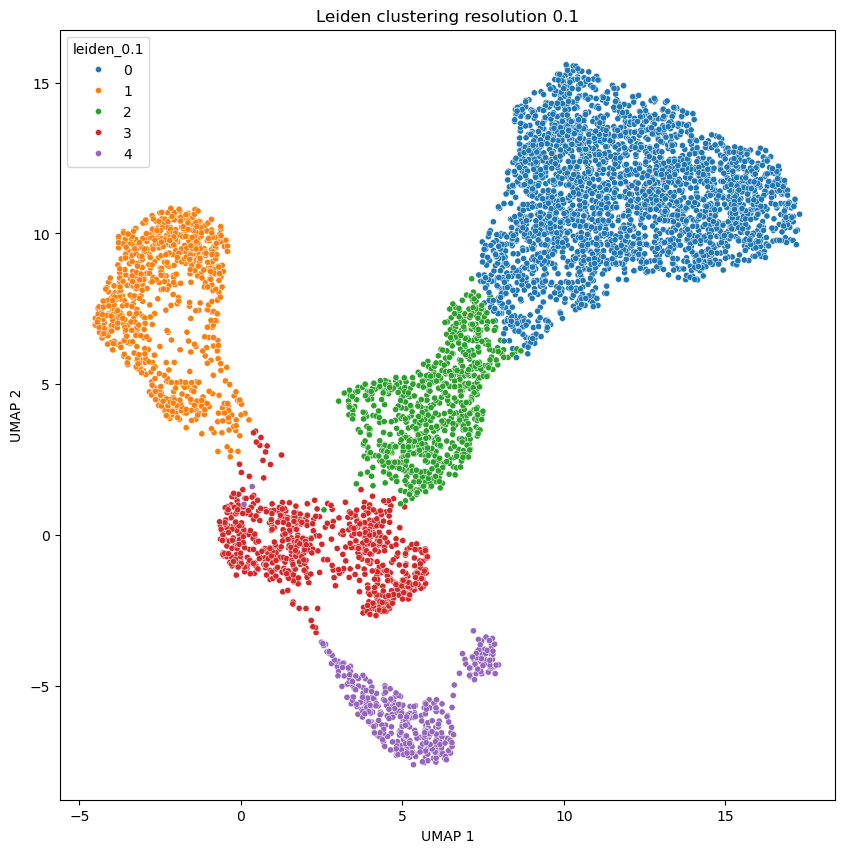

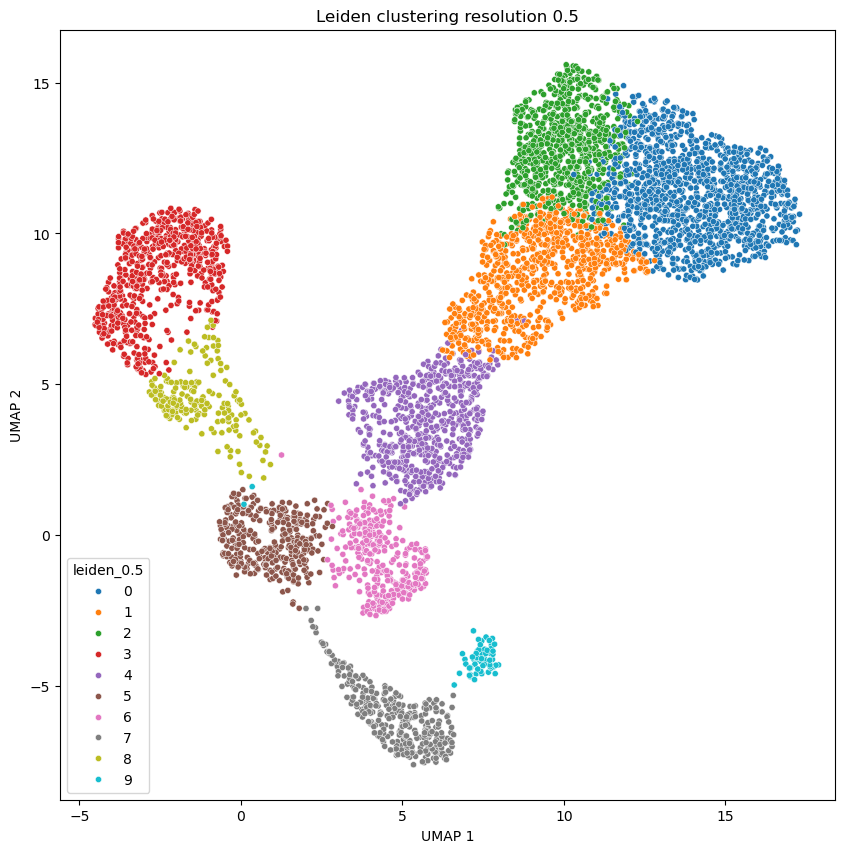

In [1330]:
for resolution in parameters["resolutions"]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    X = adata.obsm[f"X_umap_{repr}"]
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=adata.obs[f"leiden_{resolution}"], s=20, ax=ax)
    ax.set_title(f"Leiden clustering resolution {resolution}")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

    fig.savefig(f"figures/{dataset_name}/leiden_{resolution}.png", bbox_inches="tight", transparent=True, dpi=300)

# Differential expression

In [1331]:
adata.layers["logcounts"] = adata.layers["counts"].log1p()
for resolution in parameters["resolutions"]:
    scp.tl.rank_genes_groups(adata, groupby=f"leiden_{resolution}", method="wilcoxon", layer="logcounts")

    with pd.ExcelWriter(f"tables/{dataset_name}/leiden_{resolution}.xlsx") as writer:
        for cluster in adata.obs[f"leiden_{resolution}"].cat.categories:
            genes = adata.uns["rank_genes_groups"]["names"][f"{cluster}"]
            scores = adata.uns["rank_genes_groups"]["scores"][f"{cluster}"]
            logfoldchanges = adata.uns["rank_genes_groups"]["logfoldchanges"][f"{cluster}"]
            pvals = adata.uns["rank_genes_groups"]["pvals"][f"{cluster}"]
            pvals_adj = adata.uns["rank_genes_groups"]["pvals_adj"][f"{cluster}"]
            df = pd.DataFrame({"gene": genes, "score": scores, "logfoldchange": logfoldchanges, "pval": pvals, "pval_adj": pvals_adj})
            df.to_excel(writer, sheet_name=f"cluster_{cluster}", index=False)

# Save 

## Adata object

In [1332]:
adata.write(f"data_processed/adata_{dataset_name}.h5ad")

## Save analysis script

In [1335]:
# Get the current date
current_date = datetime.now().strftime("%Y%m%d")

# Construct the output file name with the current date
input_file = f"analysis_by_batch.ipynb"
output_file = f"script_versions/analysis_by_batch_{dataset[1]}_{dataset[2]}_{current_date}"

# Convert the notebook to HTML with the new file name
!jupyter nbconvert --to html "$input_file" --output "$output_file"


[NbConvertApp] Converting notebook analysis_by_batch.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 3175008 bytes to script_versions/analysis_by_batch_Eomes_mutant_rep2_20250303.html
